<div class="alert alert-block alert-danger">
<b>Alerta:</b> Para realizar adecuadamente esta unidad deberías haber hecho previamente esta o esta.
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

kB = unit.BOLTZMANN_CONSTANT_kB* unit.AVOGADRO_CONSTANT_NA

# El potencial tipo pozo armónico

## El potencial


Estudiemos el comportamiento de una partícula en un pozo armónico en contacto con un reservorio térmico estocástico. Para hacerlo más sencillo vamos a considerar que el sistema es únicamente unidimensional. Así, el potencial entonces toma la siguiente forma:

$V(x) = \frac{1}{2} K x^{2}$,

donde $V$ es el potencial, $K$ la constante "elástica" o de "stifness" y $x$ la coordenada espacial.

En adelante tomaremos los siguientes valores para caracterizar el sistema -masa-, el potencial -constante elástica-, y el universo -temperatura-:

In [2]:
m = 7.0 * unit.amu   # masa aproximadamente el peso del átomo de Litio
T = 300 * unit.kelvin   # temperatura
K = 10 * unit.kilocalorie/(unit.mole * unit.nanometers**2)   # constante elástica

<div class="alert alert-block alert-warning">
<b>Nota:</b> El valor introducido aquí para estas tres constantes será usado a lo largo de gran parte de esta unidad.
</div>

En primer lugar definamos el potencial con el que vamos a trabajar:

In [3]:
def energia_potencial (x, K):
    return 0.5*K*x**2

In [4]:
x_serie =np.linspace(-2.0, 2.0, 100, endpoint=True) * unit.nanometers
potencial_serie = energia_potencial(x_serie, K)

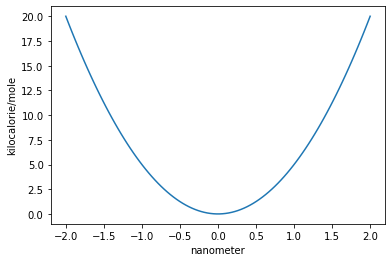

In [5]:
plt.plot(x_serie, potencial_serie)
plt.xlabel(x_serie.unit)
plt.ylabel(potencial_serie.unit)
plt.show()

Antes de continuar estudiando el sistema en contacto con un reservorio térmico estocástico dediquemos un momento a analizar el potencial y la dinámica clásica determinista del sistema. Esto motivado porque la dinámica estocástica modelada mediante la ecuación dinámica de Langevin tiene dos ingredientes adicionales al potencial: la fricción y la fuerza estocástica que llamamos aquí ruido térmico. Y tenemos que entender, antes de adentrarnos en conceptos mecánico estadísticos, el papel de la fricción.

### El oscilador armónico libre clásico

La frecuencia de oscilación de una partícula en un potencial armónico puede ser calculada analíticamente de una manera sencilla sin más que resolver la trayectoria $x(t)$ como solución de la ecuación $F=m·a$ que en este caso se puede reescribir como:

$\frac{d^{2}x}{dt^{2}}+\frac{K}{m}·x=0$

La solución de la ecuación diferencial anterior es:

$x(t)= A · cos(\sqrt{\frac{K}{m}}t+ \phi)$

Donde $A$ y $\phi$ son dos parámetros libres, amplitud y fase, y la frecuencia natural es precisamente el factor de $t$:

$\omega = \sqrt{\frac{K}{m}}$

Cuya relación con su frecuencia angular y su periodo temporal es:

$\nu = \frac{1}{2\pi} \sqrt{\frac{K}{m}}$

$T = {2\pi} \sqrt{\frac{m}{K}}$

Que para el sistema y el potencial que estamos trabajando, el periodo de la oscilación libre dura:

In [6]:
periodo = 2*np.pi*np.sqrt(m/K)

print(periodo.in_units_of(unit.picoseconds))

2.5699995686294943 ps


¿Y podemos simular estas oscilaciones? En ausencia de fricción y temperatura, la ecuación dinámica de Langevin se reduce a las clásica $\frac{d^{2}x}{dt^{2}}=-\frac{K}{m}·x$ (Ver unidad por hacer). Hagamos entonces una sencilla función para simular la trayectoria de un oscilador unidimensional con OpenMM (ver unidad X):

In [7]:
def dinamica_langevin_pozo_armonico (masa=None, K=None, temperatura=None, friccion=None,
                                     x_inicial=None, vx_inicial=None, paso_integracion=None,
                                     intervalo_guardado=None, tiempo_total=None):
    
    # Condiciones iniciales

    posiciones_iniciales  = np.zeros([1, 3], np.float32) * unit.angstroms
    posiciones_iniciales[0,0] = x_inicial.in_units_of(unit.angstroms)
    
    velocidades_iniciales = np.zeros([1, 3], np.float32) * unit.angstroms/unit.picoseconds
    velocidades_iniciales[0,0] = vx_inicial.in_units_of(unit.angstroms/unit.picoseconds)
    
    # Parámetros de la integración.

    pasos_por_ciclo_guardado = int(round(intervalo_guardado/paso_integracion))
    pasos_totales_simulados = int(round(tiempo_total/paso_integracion))
    num_ciclos_simulados = int(round(pasos_totales_simulados/pasos_por_ciclo_guardado))

    # Creación del sistema.

    sistema = mm.System()
    sistema.addParticle(masa)

    # Potencial armónico externo

    fuerza = mm.CustomExternalForce('(K/2.0) * x^2')
    fuerza.addGlobalParameter('K', K.in_units_of(unit.kilocalories_per_mole/unit.angstrom**2))
    fuerza.addParticle(0, [])
    sistema.addForce(fuerza)
    
    # Creación del integrador.

    integrador = mm.LangevinIntegrator(temperatura, friccion, paso_integracion)

    # Creación de la plataforma.

    plataforma = mm.Platform.getPlatformByName('CPU')

    # Creación del contexto.

    contexto = mm.Context(sistema, integrador, plataforma)
    contexto.setPositions(posiciones_iniciales)
    contexto.setVelocities(velocidades_iniciales)

    # Creación de arrays reporteros del tiempo, la posición y la velocidad.

    tiempos = np.zeros([num_ciclos_simulados], np.float32) * unit.picoseconds
    posiciones = np.zeros([num_ciclos_simulados, 1, 3], np.float32) * unit.angstroms
    velocidades = np.zeros([num_ciclos_simulados, 1, 3], np.float32) * unit.angstroms/unit.picosecond

    # Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

    estado = contexto.getState(getPositions=True, getVelocities=True)
    tiempos[0] = estado.getTime()
    posiciones[0] = estado.getPositions()
    velocidades[0] = estado.getVelocities()

    # Ejecuto el bucle sobre el número de periodos que vamos a simular

    for ii in range(1,num_ciclos_simulados):
        contexto.getIntegrator().step(pasos_por_ciclo_guardado)
        estado = contexto.getState(getPositions=True, getVelocities=True)
        tiempos[ii] = estado.getTime()
        posiciones[ii] = estado.getPositions()
        velocidades[ii] = estado.getVelocities()

    return tiempos, posiciones[:,0,0], velocidades[:,0,0]

Antes de comenzar una simulación siempre debes preguntarte: ¿Cúanto tiempo necesito simular?, ¿Cada cuanto tiempo debo guardar las posiciones y velocidades?, ¿Cuanto debe ser el paso de integración? Siempre debes de procurar tener información para tomar estas decisiones, la simulación a ciegas es una mala práctica que suele conllevar un mal uso de los recursos e interpretacion de los resultados a veces erronea. Pero en este caso podemos decidir facilmente:

-¿Cuanto simulamos?¿10 ns?¿0.1 ps?¿20 s? Queremos observar oscilaciones, y conocemos su periodo, ¿qué tal si simulamos al menos 40 oscilaciones?

In [8]:
tiempo_simulación = 40 * periodo

print(tiempo_simulación.in_units_of(unit.picoseconds))

102.79998274517976 ps


-¿Cada cuanto tiempo guardamos un punto en la trayectoria? Si guardamos cada poco tiempo corremos el riesgo de acabar con un fichero o vector muy pesado, de mucha memoria, innecesariamente. ¿Necesito guardar 10000 puntos por oscilación? Seguramente no. Por otro lado si el periodo de guardado de la trayectoria es muy amplio la física que voy a ver está distorsionada. Supongamos por ejemplo que nuestro intervalo de tiempo para guardar la trayectoria es igual a $2.5$ periodos de oscilación: jamas vamos a ver una oscilación y puede que no podamos ni adivinar, atendiendo a la trayectoria guardada, que nuestro sistema es un oscilador. ¿Qué te parece si represento cada oscilación con 20 puntos (y eso es una resolución muy fina)?

In [9]:
intervalo_guardado = periodo/20.0

print(intervalo_guardado.in_units_of(unit.picoseconds))

0.12849997843147473 ps


-¿Cuanto debe ser el paso de integración? A este respecto hemos dedicado una unidad (Ver unidad por hacer) en la vemos que si el paso de integración mayor a aproximadamente un décimo del periodo de oscilación podemos tener graves problemas de integración. Ya tenemos entonces un límite superior aproximado. Podemos entonces, siempre que no excedamos ese límite, elegir un paso de integración todo lo fino que queramos. Siempre claro, que no hagamos un mal uso de los recursos. Sería absurdo elegir aquí un paso de $1 fs$. Necesitaríamos entonces simular aproximadamente 2000 pasos para ver una simulación. Y esto es tiempo de cómputo que derrochamos innecesariamente. ¿Qué tal si por ejemplo en el presente caso elegimos el paso de integración aproximadamente 40 veces menor que el periodo?

In [10]:
paso_integracion = periodo/40.0

print(paso_integracion.in_units_of(unit.picoseconds))

0.06424998921573737 ps


Ya podemos realizar la simulación:

Obviamente si en ausencia de temperatura, con una dinámica clásica, situamos al sistema en su posición de equilibrio estático (en el mínimo del potencial), ahí permanece. Vamos mejor a soltar inicialmente al sistema en una posición alejada del mínimo, como por ejemplo $x=1.0 nm$ con velocidad $vx=0.0 nm/ps$:

In [11]:
tiempos, posiciones, velocidades = dinamica_langevin_pozo_armonico (masa=m, K=K, temperatura=0.0*unit.kelvin, friccion=0.0*(1/unit.picoseconds),
                                                                    x_inicial=1.0*unit.nanometers, vx_inicial=0.0*unit.nanometers/unit.picoseconds,
                                                                    paso_integracion=paso_integracion, intervalo_guardado=intervalo_guardado,
                                                                    tiempo_total= tiempo_simulación)

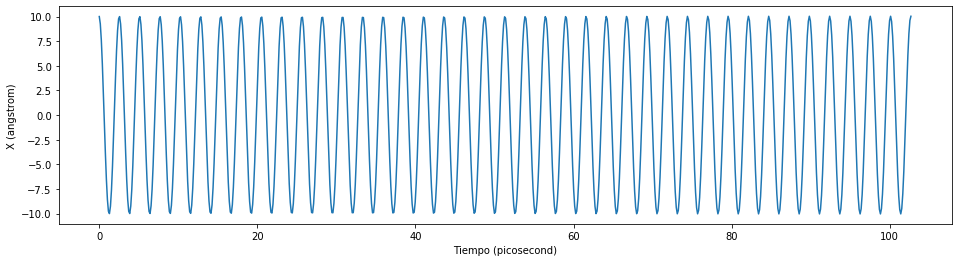

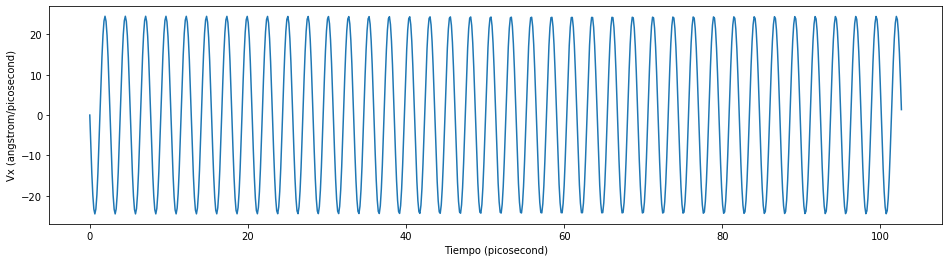

In [12]:
plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, posiciones)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("X ({})".format(posiciones.unit))
plt.show()

plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, velocidades)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("Vx ({})".format(velocidades.unit))
plt.show()

Ya observamos las 40 oscilaciones en el eje $X$. Y también cómo varía la velocidad del sistema en función de la posición y el tiempo. Antes de seguir avanzando puedes probar a variar la posición o velocidad inicial para comprobar que la amplitud temporal de la oscilación no cambia. Por contra, puedes también modificar la masa o la constante elástica y observar cómo, según lo calculado anteriormente, varía el periodo de oscilación $T = {2\pi} \sqrt{\frac{m}{K}}$.

### El oscilador armónico amortiguado

El primer ingrediente a incluir para comprender la dinámica estocástica de una partícula en un potencial armónico es la fricción. La dinámica de Langevin, a temperatura cero, nos permite simular la física de un sistema clásico amortiguado:

$m·a=-K·x-m \gamma ·v_{x}$

O en su forma de ecuación diferencial:

$\frac{d^{2}x}{dt^{2}}+\gamma·\frac{dx}{dt}+\frac{K}{m}·x=0$

Cuya solución se puede demostrar que es:

$x(t)= A ·exp(-\frac{\gamma}{2} t)· cos(\sqrt{\omega·t+ \phi})$

Y la frecuencia del oscilador $\omega$ es:

$\omega = \sqrt{\frac{K}{m}-\frac{\gamma^{2}}{4}}$

Luego el periodo de oscilación es:

$T = \frac{2\pi}{\sqrt{\frac{K}{m}-\frac{\gamma^{2}}{2}}}$

Antes de analizar la trayectoria solución, observa que en ausencia de fricción $b$ recuperamos el oscilador clásico de la sección anterior.

Simulemos ahora el nuevo escenario. Esta vez para la variable tiempo total de simulación elijamos un valor fijo que no dependa del periodo del oscilador (que ahora varía con el parámetro de fricción), por ejemplo $120 ps$ (más de 40 oscilaciones no amortiguadas). Sobre el paso de tiempo de integración, observa que si incremento la fricción aumenta el periodo hasta que $K/m - gamma^{2}/4$. Queremos ser cautelosos y no tener problemas de integración (el paso debe ser menor que aproximadamente un décimo de la oscilación -ver unidad por hacer-). Así que vamos a decidir tomando en cuenta el periodo de oscilación más pequeño, el que el sistema tiene cuando $\gamma=0 \;ps^{-1}$. En todo escenario hacemos que el paso de integración oscilación y el tiempo de guardado sean los elegidos para el caso anterior no amortiguado.

Ya podemos simular el sistema. Veamos en primer lugar 3 escenarios distintos en ausencia todavía de temperatura: $\gamma=0.1\;ps^{-1}$, $b=1.0\;ps^{-1}$ y $b=10.0\;ps^{-1}$

In [26]:
gamma = 0.05/unit.picosecond

In [27]:
periodo = 2*np.pi/np.sqrt(K/m - (gamma**2)/4.0)

print(periodo.in_units_of(unit.picoseconds))

2.5701339451826324 ps


In [28]:
tiempos, posiciones, velocidades = dinamica_langevin_pozo_armonico (masa=m, K=K, temperatura=0.0*unit.kelvin, friccion=gamma,
                                                                    x_inicial=1.0*unit.nanometers, vx_inicial=0.0*unit.nanometers/unit.picoseconds,
                                                                    paso_integracion=paso_integracion, intervalo_guardado=intervalo_guardado,
                                                                    tiempo_total= tiempo_simulación)

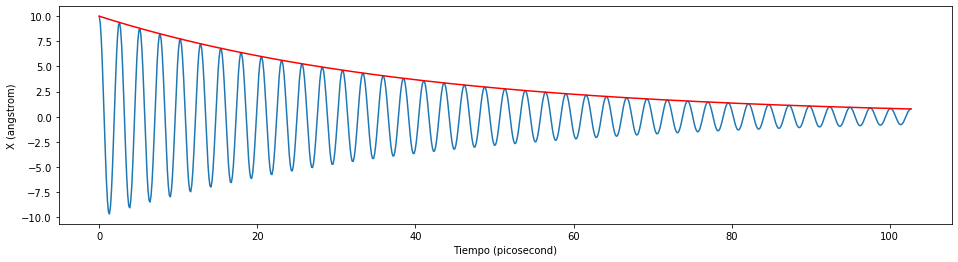

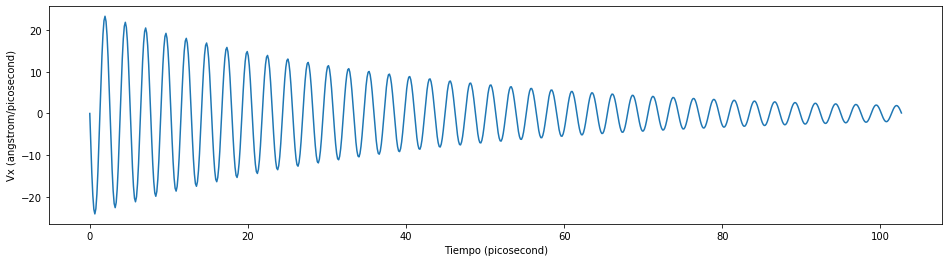

In [29]:
def decaimiento_amplitud(A,fricción,t):
    
    return A*np.exp(-(fricción/2.0)*t)

referencia_decaimiento = decaimiento_amplitud(1.0*unit.nanometers, gamma, tiempos)

plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, posiciones)
plt.plot(tiempos, referencia_decaimiento.in_units_of(unit.angstroms), 'r-')
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("X ({})".format(posiciones.unit))
plt.show()

plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, velocidades)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("Vx ({})".format(velocidades.unit))
plt.show()

Habrás observado que aumentando el valor de la fricción disminuye el número de oscilaciones hasta quedar en la posición de equilibrio, de manera permanente. De hecho, para valores de $\gamma \gt \sqrt{\frac{4K}{m}}$ la solución analítica no existe porque el sistema decae diréctamente sin realizar ninguna oscilación. Te habrás preguntado por qué para $\gamma=10.0 ps^{-1}$ la celda del cálculo del periodo da error, ¿verdad?. Pues el motivo es que el argumento de la raiz cuadrada se hace negativo, indicando que su solución ya no es real sino compleja: ya no existe periodo y por lo tanto el sistema ya no se comporta como un oscilador. Sin embargo el sistema si tiene trayectoria, la simulación tiene sentido como ya habrás visto. No te extrañará entonces que digamos que según el valor de la fricción existen dos regímenes y un caso crítico. Si $\gamma \lt \sqrt{\frac{4K}{m}}$ decimos que el sistema es un oscilador sub-amortiguado que relaja al estado estacionario relajando exponencialmente su amplitud. Si $\gamma = \sqrt{\frac{4K}{m}}$ encontramos al sistema en su amortiguamiento crítico, el relajamiento es una trayectoria exponencial en función del tiempo sin ninguna oscilación. Y si Si $\gamma \gt \sqrt{\frac{4K}{m}}$ el sistema está sobre-amortiguado: su decaimiento está descrito analíticamente por la suma de dos exponenciales (sin oscilación ninguna). Puedes volver a correr el sistema con el valor de la fricción que desees teniendo el cuenta que el valor crítico de la fricción es:

In [30]:
print(np.sqrt(4*K/m).in_units_of(unit.picoseconds**(-1)))

4.88963919206432 /ps


En este momento todavía no estamos simulando la dinámica de langevin de una partícula en un pozo harmónico. El ingrediente que falta es la entrada de energía al sistema mediante su acoplo con la fuerza de ruido térmico. Es decir, como vemos en cualquiera de los tres escenarios propuestos, la introducción de la fricción o 'damping' unicamente supone poner en contacto a nuestra partícula con un entorno que disipa energía, que absorbe energía. Al sistema lo ponemos en unas condiciones iniciales, con cierta energía potencial y cinética, pero al comenzar la dinámica el sistema relaja durante un periodo transitorio a su estado de equilibrio: el mínimo de energía con energía total nula. A esto se le llama comenzar con unas condiciones fuera del equilibrio para relajar al equilibrio. Prueba por ejemplo a correr la dinámica con cualquier combinación que desees de posición y velocidad inicial, en todas las situaciones, pasado un cierto tiempo transitorio, el sistema equilibrará disipando toda su energía. 

### El oscilador armónico amortiguado en contacto con un reservorio térmico estocástico

El reservorio térmico estocástico, el "universo" al que se encuentra acoplado el sistema, se modela mediante dos términos en la ecuación dinámica de Langevin: la disipación y la fluctuación. Como vimos en la sección anterior, la disipación puede ser implementada sin la fluctuación, sin embargo la fluctuación no puede ser modelada sin fricción. La fuerza estocástica que representa el ruido térmico es una función de distribución aleatoria gausiana con una anchura dependiente de la temperatura y de la fricción, de la difusión:

$XXX$

Prueba por ejemplo a correr una simulación de Langevin a 300 Kelvin pero sin fricción, y con condiciones iniciales estacionarias para el oscilador clásico no amortiguado ($x=0$ y $v_{x}=0$): 

In [31]:
tiempos, posiciones, velocidades = dinamica_langevin_pozo_armonico (masa=m, K=K, temperatura=300.0*unit.kelvin, friccion=0.0/unit.picoseconds,
                                                                    x_inicial=0.0*unit.nanometers, vx_inicial=0.0*unit.nanometers/unit.picoseconds,
                                                                    paso_integracion=paso_integracion, intervalo_guardado=intervalo_guardado,
                                                                    tiempo_total= tiempo_simulación)

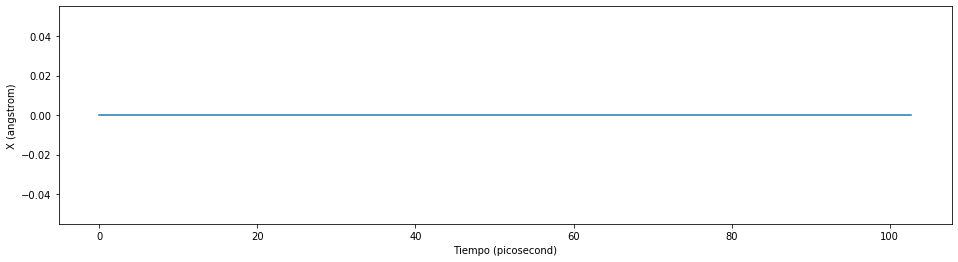

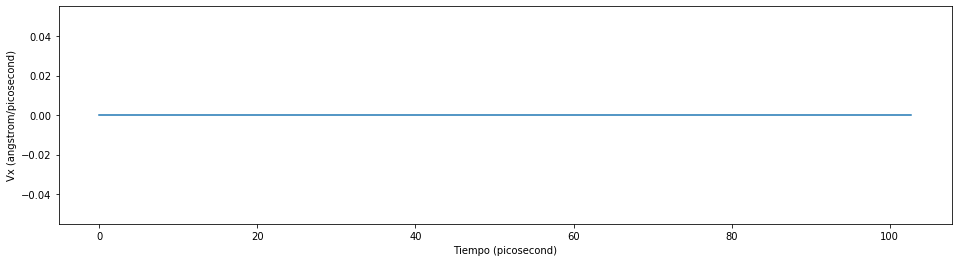

In [32]:
plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, posiciones)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("X ({})".format(posiciones.unit))
plt.show()

plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, velocidades)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("Vx ({})".format(velocidades.unit))
plt.show()

En ausencia de fricción el medio no existe, no hay reservorio térmico. Tenemos un oscilador clásico no amortiguado. Ahora, incrementa el valor de la fricción a la misma temperatura ($T=300 \;K$). Por ejemplo con un valor de $\gamma=1.0 \;ps^{-1}$ y con las mismas condiciones iniciales ($x=0$ y $v_{x}=0$):

In [33]:
tiempos, posiciones, velocidades = dinamica_langevin_pozo_armonico (masa=m, K=K, temperatura=300.0*unit.kelvin, friccion=1.0/unit.picoseconds,
                                                                    x_inicial=0.0*unit.nanometers, vx_inicial=0.0*unit.nanometers/unit.picoseconds,
                                                                    paso_integracion=paso_integracion, intervalo_guardado=intervalo_guardado,
                                                                    tiempo_total= tiempo_simulación)

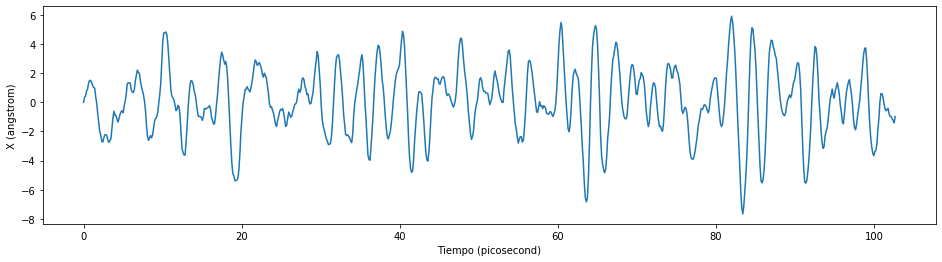

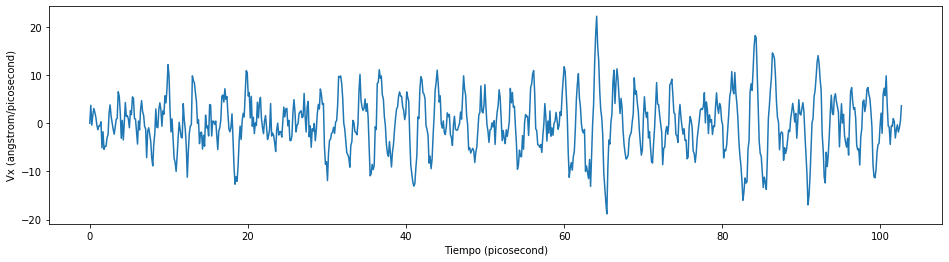

In [34]:
plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, posiciones)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("X ({})".format(posiciones.unit))
plt.show()

plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, velocidades)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("Vx ({})".format(velocidades.unit))
plt.show()

El sistema tiene una entrada de energía y abandona su posición de reposo, pero ya no se comporta dibujando unas oscilaciones clásicas. Al estar ahora en contacto con un generador de fuerzas aleatorias (golpes externos), la partícula comienza a moverse de manera aleatoria también pero confinada en el pozo armónico. Puedes jugar a generar trayectorias a mayor o menor temperatura, con más o menos fricción, esto educará tu intuición sobre lo que es una dinámica de langevin. Observa que a pesar de tener un término de fricción el sistema no acaba en un estado de equilibrio sin energía en el mínimo del potencial, ni tampoco al tener una inyección continua de agitación térmica incrementa su energía explorando cada vez regiones más alejadas del pozo y con velocidades cada vez mayores. Existe un balance entre la disipación y la fluctuación que hace que nuestra partícula se acomode a una situación de equilibrio en la que el histograma de su posición, o el de su velocidad, tras un tiempo suficientemente largo sea característico de las condiciones termodinámicas del sistema (de la temperatura, en este caso).

Vamos a representar estos histogramas esta vez con un tiempo de simulación un poco más elevado, $10 \;ns$ por ejemplo (tarda un par de minutos):

In [35]:
tiempos, posiciones, velocidades = dinamica_langevin_pozo_armonico (masa=m, K=K, temperatura=300.0*unit.kelvin, friccion=1.0/unit.picoseconds,
                                                                    x_inicial=0.0*unit.nanometers, vx_inicial=0.0*unit.nanometers/unit.picoseconds,
                                                                    paso_integracion=paso_integracion, intervalo_guardado=intervalo_guardado,
                                                                    tiempo_total= 10*unit.nanoseconds)

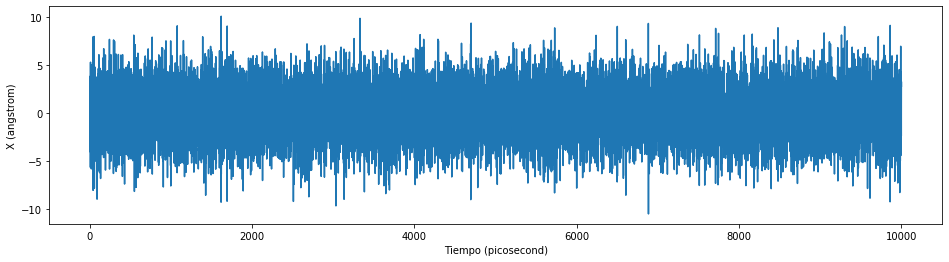

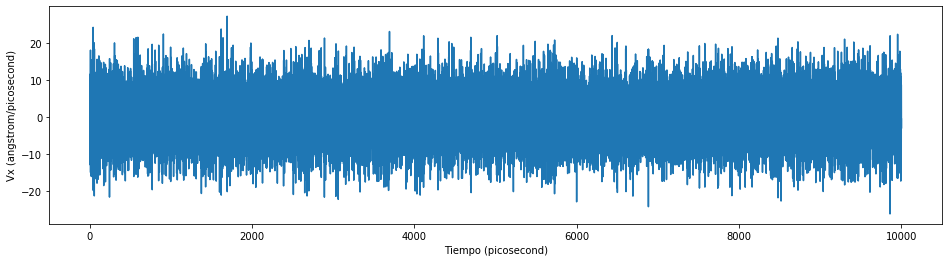

In [36]:
plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, posiciones)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("X ({})".format(posiciones.unit))
plt.show()

plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, velocidades)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("Vx ({})".format(velocidades.unit))
plt.show()

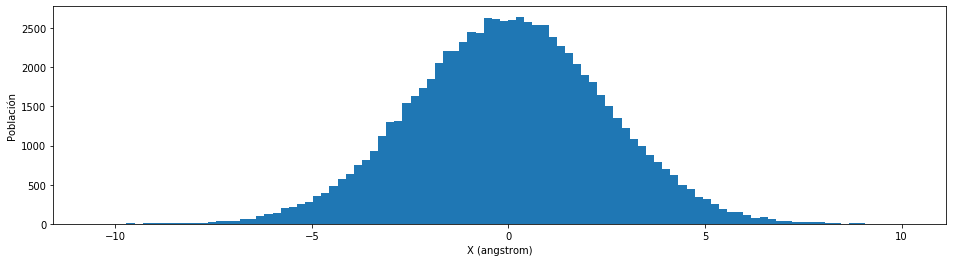

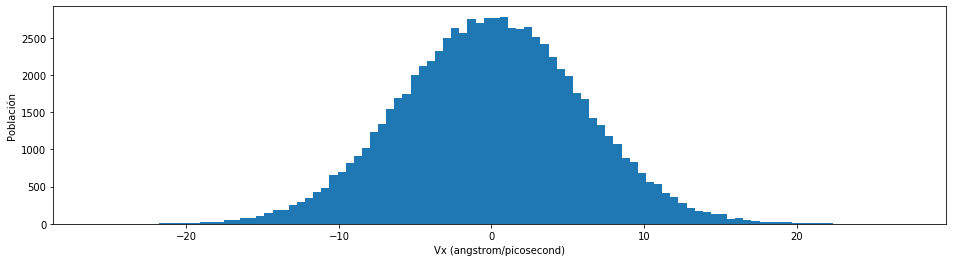

In [40]:
n, bins, patches = plt.hist(posiciones, bins=100)
plt.xlabel("X ({})".format(posiciones.unit))
plt.ylabel("Población")
plt.show()

n, bins, patches = plt.hist(velocidades, bins=100)
plt.xlabel("Vx ({})".format(velocidades.unit))
plt.ylabel("Población")
plt.show()

Los histogramas tienen forma gaussiana, producto de la forma del potencial, y como veremos son perfectamente predecibles analíticamente. Puedes jugar de nuevo a cambiar por ejemplo el valor de la fricción sin cambiar la temperatura y verás que el histograma no cambia. La probabilidad de tener una velocidad o de visitar cierta posición, no depende de la fricción. Sin embargo, como puedes ver si bajas o subes la temperatura, sí depende de esta última. Vemos por ejemplo que para $T=300 \;K$ visitar la posición $x=10$ es áltamente improbable, así como tener una velocidad $vx=-25$. ¿Y qué sucede si comenzamos una simulación con esas condiciones? Estamos entonces comenzando una simulación con el sistema en unas condiciones "bastante" fuera del equilibrio. La situación inicial del sistema es "bastante" incompatible con las condiciones en las que está. Por eso, el sistema rápidamente disipa energía y se acomoda a su comportamiento en equilibrio: alcanza un regimen en el que se mueve de manera browniana con una cierta probabilidad de visita de la coordenada x compatible con el estado termodinámico (aquí, temperatura) y adquiere unas velocidades cuyas probabilidades de ser adquiridas son también compatibles con la temperatura. Haz la prueba:

In [41]:
tiempos, posiciones, velocidades = dinamica_langevin_pozo_armonico (masa=m, K=K, temperatura=300.0*unit.kelvin, friccion=1.0/unit.picoseconds,
                                                                    x_inicial=10.0*unit.nanometers, vx_inicial=-25.0*unit.nanometers/unit.picoseconds,
                                                                    paso_integracion=paso_integracion, intervalo_guardado=intervalo_guardado,
                                                                    tiempo_total= 10*unit.nanoseconds)

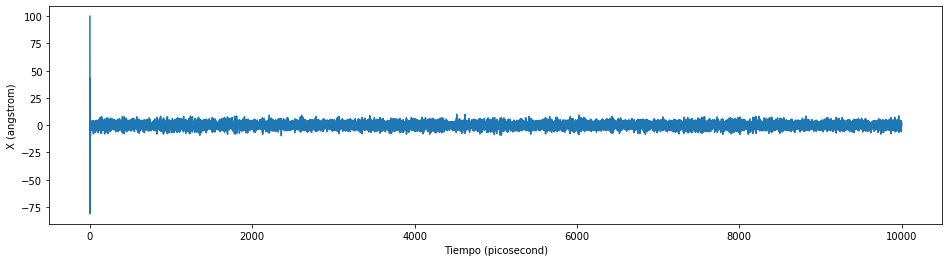

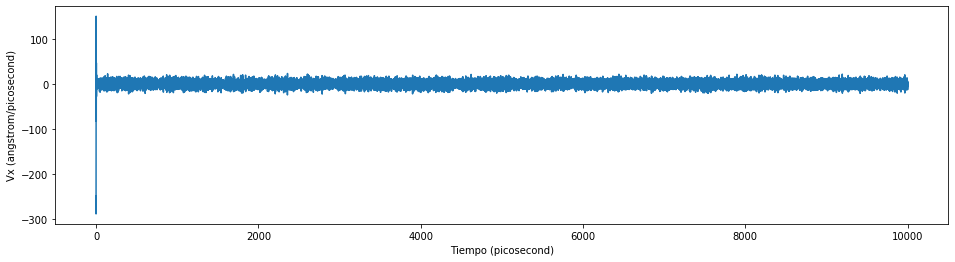

In [42]:
plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, posiciones)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("X ({})".format(posiciones.unit))
plt.show()

plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tiempos, velocidades)
plt.xlabel("Tiempo ({})".format(tiempos.unit))
plt.ylabel("Vx ({})".format(velocidades.unit))
plt.show()

Despues de un breve tiempo de relajación, el sistema gana o disipa energía acomodándose a su estado "acoplado" con el universo (presión, volumen, temperatura y potencial químico). Decimos entonces que el sistema ha "termalizado" o queda "equilibrado": su posición en el espacio de coordenadas y momentos es muy probablemente compatible con el estado termodinámico en el que se encuentra. Podemos por ejemplo en este último caso construir el histograma desechando la primera parte de la simulación para ver que es igual que lo observado anteriormente:

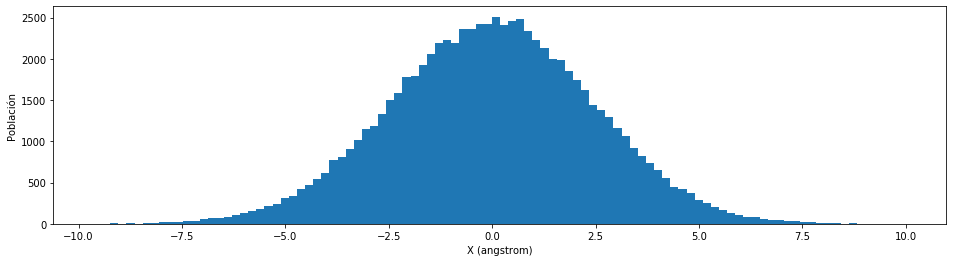

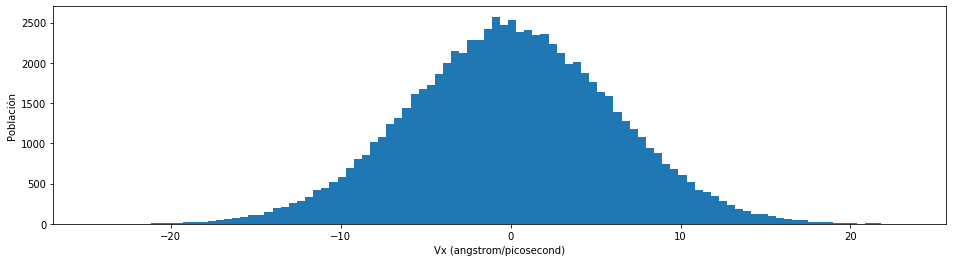

In [43]:
frames_desechados = 1000

n, bins, patches = plt.hist(posiciones[frames_desechados:], bins=100)
plt.xlabel("X ({})".format(posiciones.unit))
plt.ylabel("Población")
plt.show()

n, bins, patches = plt.hist(velocidades[frames_desechados:], bins=100)
plt.xlabel("Vx ({})".format(velocidades.unit))
plt.ylabel("Población")
plt.show()

En una dinámica estocástica de un sistema, en contacto con un reservorio termodinámico, en ciertas condiciones de presión, temperatura, volumen y potencial químico, no podemos predecir la trayectoria. Pero podemos predecir la probabilidad de que el sistema se encuentre en un cierto punto o región del espacio de coordenadas y momentos. Y gracias a ello, podemos predecir los valores promedio y la función de distribución de probabilidad de cualquier observable. Para ello, lo único que necesitamos conocer es el peso de Boltzmann.

<div class="alert alert-block alert-info">
<b>Idea:</b> Sería conveniente hacer referencia a un notebook en el que se ilustre que el paso de integración debe ser
    al menos 10 veces menor que el periodo de oscilación y otro que sirva como primer ejemplo de campo de fuerzas parametrizado
    donde el pozo armonico representa la masa reducidad de la molecula diatomica CO para ajustar la K del potencial haciendo uso
    de la frecuencia caracteristica de vibración segun su espectro de absorción.
</div>

## Peso de Boltzmann

### Función de distribución del peso de Boltzmann

La función distribución de peso de Boltzmann se define para cualquier estado del sistema determinado por su cordenada espacial $x$ y su momento $p_{x}$, siendo $p_{x}=v_{x}/m$, como:

$w(x,p_{x})=\exp(-\frac{H(x,p_{x})}{\mathit{K}_{B}T})$

Donde el hamiltoniano, en este caso la energía total del sistema, es:

$H(x,p_{x}) = \frac{p_{x}^{2}}{2m} + \frac{1}{2} K x^{2}$

### Peso de una región del espacio o "macroestado"

Para el propóxito de esta subsección definimos "estado", o "macroestado" del sistema, como una porción del volumen total del espacio de coordenadas y momentos. Por ejemplo, podemos definir un "estado" mediante los dos intervalos $x \in [1, 3]$ y $p_{x} \in [-2, 2]$. El sistema se encontrará en dicho "estado" cuando se cumplan a la vez las dos condiciones, el valor de $x$ del sistema debe estar en el intervalo $[1, 3]$ y ademas el valor de $p_{x}$ debe estar en $[-2, 2]$. De esta manera, podemos ahora definir el peso de Boltzmann de dicho "estado" mediante la integral (la suma infinitesimal) de la función de distribución del peso en el volumen definido:

$w(1 \leq x \leq 3, -2 \leq p_{x} \leq 2) = \int_{1}^{3} \int_{-2}^{2} \exp(-\frac{H(x,p_{x})}{\mathit{K}_{B}T}) \,dx\,dp_x$

De la misma manera puedo definir el peso total del espacio de coordenadas y momentos como:

$W = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \exp(-\frac{H(x,p_{x})}{\mathit{K}_{B}T}) \,dx\,dp_x$

### Función de distribución del peso de Boltzmann únicamente en el espacio de coordenadas

Definiremos "estado conformacional", o "macroestado conformacional" del sistema, como la porción del volumen únicamente del espacio de coordenadas. Sin importar cual sea el momento. Por ejemplo, en una dimensión, un "estado conformacional" podría ser definido como el segmento de $x \in [0, 0.25]$ con $p_{x} \in (-\infty, \infty)$. Esto significa que dado que $x$ y $p_{x}$ son sucesos independientes -como se ve en la factorización del hamiltoniano-, podemos reescribir $w(x,p_{x})$ como

$w(x,p_{x})= w_{cin}(p_{x}) · w_{pot}(x),$

con

$w_{cin}(p_{x}) = \exp(-\frac{1}{\mathit{K}_{B}T} \frac{p_{x}^{2}}{2m})$

y

$w_{pot}(x) = \exp(-\frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2})$.

Así, la distribución de pesos únicamente en el espacio de las $x$, integrando el peso de los momentos, puede ser definida como como:

$w(x) = \int_{-\infty}^{+\infty} w(x,p_{x}) \,dp_{x} = \exp(- \frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2}) \int_{-\infty}^{+\infty} \exp(- \frac{1}{\mathit{K}_{B}T} \frac{p_{x}^{2}}{2m} \,dp_{x})$

Pero esta expresión es en realidad más sencilla. La integral de una función gaussiana es resoluble entre $-\infty$ y $\infty$:

$\int_{-\infty}^{+\infty} \exp(- a·x^{2}) \,dx = \sqrt{\frac{\pi}{a}}$

Así que la integral de la componente del peso de Boltzman dada por la energía cinética es una constante que sólo depende de la temperatura y la masa, y que podemos llamar "peso total de la parte cinética", $W_{p_{x}}$:

$ W_{p_{x}} \equiv \int_{-\infty}^{+\infty} \exp(- \frac{1}{\mathit{K}_{B}T} \frac{p_{x}^{2}}{2m} \,dp_{x}) = \sqrt{2 \pi m \mathit{K}_{B}T}$

Por último reescribimos:

$w(x) = W_{p_{x}} \exp(- \frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2})$

Esta última es la expresión correcta del peso de Boltzmann de la coordenada espacial, integrando la parte cinética. Como veremos más abajo, el hecho de integrar la cinética tiene todo el sentido en el marco en el que nosotros trabajamos. La estadística que vamos a hacer habitualmente, la termodinámica, no depende de las velocidades (o de los momentos). Por eso con frecuencia abusamos del lenguage ignorando la constante $W_{p_{x}}$ y decimos -erroneamente- que:

$w(x) = \exp(- \frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2})$

Veremos en la siguiente subsección que podemos "ignorar" el peso de la parte cinética si la parte potencial no depende de los momentos y sólo atendemos a observables que dependen únicamente de las coordenadas espaciales.

<div class="alert alert-block alert-info">
<b>Idea:</b> Sería conveniente hacer referencia a un notebook en el que desde un punto de vista puramente teórico veamos la función de
    distribución de Boltzmann y cómo esta es deducida.
</div>

Ahora si, para ver la forma de la distribución de pesos de Boltzmann determinada por un potencial harmónico en el espacio de las $x$:

In [ ]:
def funcion_distribucion_peso(x, K, energia_potencial, temperatura):
    return np.exp(-energia_potencial(x, K)/(kB * temperatura))

In [ ]:
distribucion_pesos_serie = funcion_distribucion_peso(x_serie, K, energia_potencial, T)

In [ ]:
plt.plot(x_serie, distribucion_pesos_serie)
plt.xlabel(x_serie.unit)
plt.show()

Y podemos por último calcular el peso de Boltzmann de una región del espacio de coordenadas $x \in [A,B]$ como la integral de dicho peso entre los límites A y B:

In [ ]:
def peso_de_region(limite_inferior, limite_superior, K, potencial, temperatura, numero_de_discretizaciones):
    
    x_series = np.linspace(limite_inferior, limite_superior, numero_de_discretizaciones+1, endpoint=True)
    delta_x = x_series[1]-x_series[0]
    
    area = 0.0
    for x in x_series[:-1]:
        y = np.exp(-potencial(x * unit.nanometers, K)/(kB * temperatura))
        area += y*delta_x
    
    return area

Supongamos que el estado conformacional se define como $x \in [0.0, 0.25]$:

In [ ]:
peso_de_region(0.0, 0.25, K, energia_potencial, T, 2500)

O podemos también aproximarnos al calculo del peso total del espacio conformacional. Hagamos los límites de la integral lo "suficientemente" distantes para suponer que el peso que estamos dejando fuera es una cantidad lo "suficientemente" pequeña. Viendo la función de distribución antes representada consideremos como aproximación al peso total el intervalo [-2.0, 2.0]:

In [ ]:
peso_de_region(-2.0, 2.0, K, energia_potencial, T, 40000)

<div class="alert alert-block alert-danger">
<b>Alerta:</b> El peso total debería de calcularse entre $-\infty$ y $\infty$. Como numéricamente esto es imposible, debemos elegir
    unos límites asumiendo que el peso del espacio que quedó fuera de los límites es una cantidad despreciable. En nuestro caso, viendo
    la gráfica anterior de la función de distribución del peso dado por el potencial armónico sobre la coordenada espacial, sabiendo que
    esta está siempre definida positiva -no tiene cortes con $y=0$- y tiende asintoticamente a $0$ cuando $x$ tiende a $-\infty$ o $\infty$,
    para el caso de $K=10 \;kcal/(mol · nm^{2})$ y $T= 300 \;K$, asumimos que el peso de la región $x \in (-\infty,-2) \cup (2,\infty)$ es
    insignificante. Esta elección de región significativa para el cálculo del peso total no siempre puede hacerse tan fácilmente.
 </div>

¿Esta este último valor próximo al resultado de la integral numérica para el peso total?

$W_{pot}=\int_{-\infty}^{+\infty} \exp(- \frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2}) \,dx = \sqrt{\frac{2\pi\mathit{K}_{B}T}{K}}$

In [ ]:
np.sqrt((2*np.pi*kB*T)/K)._value

### Función de distribución del peso de Boltzmann únicamente en el espacio de momentos

In [ ]:
Definamos también una función que calcule la energía cinética del sistema en función de su velocidad $v_{x}$:

In [ ]:
def energia_cinetica (vx, m):
    return 0.5*m*vx**2

## Probabilidad

El "microestado de $x$" comprenderá todas las situaciones en las que el sistema se encuentre en el intervalo $[x,x+dx)$. Y lo mismo podemos definir para el momento $p_{x}$ mediante la anchura infinitesimal $dp_{x}$. ¿Y esto por qué? Matemáticamente estamos trabajando en un espacio continuo, no discreto. Si queremos preguntarnos cual es la probabilidad de encontrar al sistema con exactamente su coordenada $x=1.0$ y momento $p_{x}=-2.0$ debemos tener en cuenta que dicha probabilidad será $0$. De nuevo, ¿y esto por qué?. No es porque esa circunstancia no tenga un peso estadísitico, que sí lo sitene, sino porque el volumen que estamos delimitando para encontrar al sistema es cero. Piensa que no hemos especificado que la coordenada espacial del sistema se encuentre en el intervalo $[0.9999, 1.0001)$, tampoco en $[0.99999999, 1.00000001)$, si no exactamente en $x=1.0000000$. Eso estrictamente hablando, es un punto (un segmento de anchura 0). Nunca el sistema se encontrará allí. Por eso aproximamos, y decimos que la probabilidad de encontrar al sistema en un punto debe ser multiplicada por la "anchura del punto" $dx$ (siendo $dx$ un número infinitamente pequeño que tiende a cero).

Dicho esto, ya podemos definir la probabilidad de que nuestro sistema se encuentre en un cierto $x$ y un cierto $p_{x}$ como el 

$P(x,p_{x}) = \frac{w(x,p_{x})}{W} \,dx$

Donde, como ya vimos anteriormente, el peso total es la suma de pesos sobre todo el espacio de coordenadas y momentos. Dado que estamos en un espacio continuo y no discreto, la suma pasa a ser resuelta como integral:

$W = \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} w(x,p_{x}) \,dx\,dp_{x}$

### Probabilidad de un suceso únicamente en el espacio de coordenadas

La gran mayoría, si no la totalidad, de situaciones en las que trabajamos requieren modelar el comportamiento de observables únicamente descritos en el espacio de coordenadas. Como se explicó en la sección anterior, podemos por ejemplo preguntarnos cuál es la probabilidad de que nuestra partícula se encuentre en la región $x \in [0, 0.25]$ siendo su momento cualquiera $p \in [-\infty, \infty]$. En ese caso estamos integrando el momento de tal manera que:

$P(0 \leq x \leq 0.25) = P(0 \leq x \leq 0.25, -\infty \leq p_{x} \leq \infty) = \int_{0}^{0.25} \int_{-\infty}^{+\infty} \frac{w_{pot}(x)w_{cin}(p_{x})}{W_{pot}W_{cin}} \,dx \,dp_{x} = \int_{0}^{0.25} \frac{w_{pot}(x)}{W_{pot}} \,dx \int_{-\infty}^{+\infty} \frac{w_{cin}(p_{x})}{W_{cin}} \,dp_{x} = \int_{0}^{0.25} \frac{w_{pot}(x)}{W_{pot}} \,dx $

Al integrar la parte cinética, ésta sólo depende de los momentos mientras que la parte potencial sólo depende de las posiciones, observamos que es estríctamente correcto calcular la probabilidad de un suceso únicamente determinado por el espacio de coordenadas como:

$P(x) = \frac{w_{pot}(x)}{W_{pot}} \,dx$

Y abusando un poco del lenguaje, en el entendido que estamos siendo conscientes de que hemos integrado la parte cinética:

$P(x) = \frac{w_{pot}(x)}{W_{pot}} \,dx$,

donde $w \equiv w_{pot}$ y $W \equiv W_{pot}$.

De estas manera ya podemos entonces calcular la probabilidad de que el sistema se encuentre en una cierta región o "macroestado conformacional" $x \ in [a,b]$ en el caso de nuestro potencial armónico:

$P(a \leq x \leq b) = \frac{1}{W} \int_{a}^{b} w(x) \,dx$,

Veamos por ejemplo la probabilidad de que el sistema se encuentre en la región $x \in [0, 0.25]$:

In [ ]:
peso_region = peso_de_region(0.0, 0.25, K, energia_potencial, T, 2500)
peso_total = peso_de_region(-2.0, 2.0, K, energia_potencial, T, 40000)

probabilidad_region = peso_region / peso_total

print(probabilidad_region)

### Probabilidad relativa de dos sucesos únicamente en el espacio de coordenadas

Calcular la probabilidad relativa entre dos sucesos conlleva una enorme ventaja si lo comparamos con el cálculo de la probabilidad absoluta de un único suceso: no necesitamos conocer el peso en espacio en su totalidad. Para ilustrar esto supongamos que quiero conocer cuanto más es probable que encuentre al sistema en la región $x \in [0, 0.25)$ que en $x \in [0.25, 0.5)$ sin importar cual sea el momento $p_{x}$:

$\frac{P(0 \leq x \lt 0.25)}{P(0.25 \leq x \lt 0.50)}$ = $\frac{\frac{1}{W} \int_{0}^{0.25} w(x) \,dx}{\frac{1}{W} \int_{0.25}^{0.50} w(x) \,dx} = \frac{\int_{0}^{0.25} w(x) \,dx}{\int_{0.25}^{0.50} w(x) \,dx}$

<div class="alert alert-block alert-info">
<b>Idea:</b> Sería conveniente hacer referencia a un notebook en el que desde un punto de vista puramente teórico veamos unas nociones
    básicas sobre probabilidad y estadística: probabilidad condicionada, probabilidad compuesta, correlación...
</div>

El cálculo de la probabilidad relativa requiere conocer el peso de boltzmann en las regiones de ambos sucesos, pero no fuera de ellos. No necesitamos calcular el peso total. Y esto, cuando se trabaja computacionalmente con sistemas grandes y pesados, es una ventaja.

Hagamos ahora el cálculo numérico para conocer cuan más probable es estar en una región que en otra:

In [ ]:
peso_region_1 = peso_de_region(0.0, 0.25, K, energia_potencial, T, 2500)
peso_region_2 = peso_de_region(0.25, 0.50, K, energia_potencial, T, 2500)

probabilidad_relativa = peso_region_1 / peso_region_2

print(probabilidad_relativa)

### Valor esperado promedio de observables

Por último ya podemos calcular el valor esperado que obtendremos al medir observables, en este caso que únicamente dependan de las coordenadas del sistema, como por ejemplo la posición promedio del sistema, o la fluctuación cuadrática promedio del sistema a cierta temperatura. Conocida la expresión de la densidad de probabilidad, o probabilidad de una región infinifinitesimal $P(x)dx$, el valor esperado de un observable $A$ es:

$<A(x)> = \int_{-\infty}^{\infty} A(x)·P(x) \,dx$

Es decir, la suma continua (integral) el valor que toma $A$ en cada región infinitesimal del espacio conformacional por la probabilidad de dicha región. O dicho de otra manera, la integral del valor que toma $A$ en cada punto pesado por el peso de Boltzmann:

$<A(x)> = \frac{1}{W} \int_{-\infty}^{\infty} A(x)·w(x) \,dx$

#### Ejemplo 1: Posición Promedio

Podemos calcular la posición promedio de dos maneras distintas, analíticamente y numéricamente -computacionalmente-. Veamos en primer lugar analícamente:

$<x> = \frac{1}{W} \int_{-\infty}^{\infty} x·w(x) \,dx = \frac{1}{W} \int_{-\infty}^{\infty} x· \exp(- \frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2}) \,dx = 0$,

ya que la función a integrar es simétrica impar.

Y numéricamente:

In [ ]:
def observable(x):
    return x

In [ ]:
def observable_esperado( A, limite_inferior, limite_superior, K, potencial, temperatura, numero_de_discretizaciones):
    
    x_series = np.linspace(limite_inferior, limite_superior, numero_de_discretizaciones+1, endpoint=True)
    delta_x = x_series[1]-x_series[0]
    
    A_pesado = 0.0 * unit.nanometers
    peso_total = 0.0
    
    for x in x_series[:-1]:
        valor_A = A(x * unit.nanometers)
        peso = np.exp(-potencial(x * unit.nanometers, K)/(kB * temperatura))
        A_pesado += valor_A * peso * delta_x
        peso_total += peso * delta_x
    
    return A_pesado/peso_total

In [ ]:
posicion_promedio = observable_esperado(observable, -2.0, 2.0, K, energia_potencial, T, 40000)

print(posicion_promedio)

#### Ejemplo 2: Desviación Cuadrática promedio con respecto al valor promedio esperado

Podemos calcular la desviación cuadrática promedio con respecto al valor promedio esperado promedio de nuevo de dos maneras distintas, analíticamente y numéricamente -computacionalmente-. Veamos en primer lugar analícamente:

$<(x - <x>)^2> = <(x^2 + <x>^2 -2x<x>)> = <x^2> + <x>^2 - 2<x>^2 = <x^2> - <x>^2 $

En el ejemplo anterior ya vimos que con el potencial armónico que hemos definido la posición promedio esperada es $0$, así que en este caso que nos ocupa:

$<(x - <x>)^2> = <x^2>$

Así que:

$<x^2> = \frac{1}{W} \int_{-\infty}^{\infty} x^2·w(x) \,dx = \frac{1}{W} \int_{-\infty}^{\infty} x^2· \exp(- \frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2}) \,dx$.

Esta función es resoluble analíticamente. La forma general de la solución entre $-\infty$ y $\infty$:

$\int_{-\infty}^{+\infty} x^{2} \exp(- a·x^{2}) \,dx = \sqrt{\frac{\pi}{4·a^3}}$

Y dado que conocemos la solución analítica del peso total:

$W=\int_{-\infty}^{+\infty} \exp(- \frac{1}{\mathit{K}_{B}T} \frac{1}{2} K x^{2}) \,dx = \sqrt{\frac{2\pi\mathit{K}_{B}T}{K}}$

Y aplicado a nuestro caso definiendo $a=\frac{1}{\mathit{K}_{B}T} \frac{1}{2} K$:

$<x^2> = \frac{1}{W} \int_{-\infty}^{\infty} x^2· \exp(- a x^{2}) \,dx = \frac{\sqrt{\frac{\pi}{4·a^3}}}{\sqrt{\frac{\pi}{a}}} = \frac{1}{2a}$

Así que en su expresión completa:

$<x^2> = \frac{\mathit{K}_{B}T}{K}$ 

Cuya solución para las condiciones de temperatura y constante del potencial armónico $K$ es:

In [ ]:
print((kB*T)/K)

Así mismo lo podemos calcular numéricamente:

In [ ]:
def observable(x):
    return x**2

def observable_esperado( A, limite_inferior, limite_superior, K, potencial, temperatura, numero_de_discretizaciones):
    
    x_series = np.linspace(limite_inferior, limite_superior, numero_de_discretizaciones+1, endpoint=True)
    delta_x = x_series[1]-x_series[0]
    
    A_units = A(unit.nanometers)
    A_pesado = 0.0 * A_units
    peso_total = 0.0
    
    for x in x_series[:-1]:
        valor_A = A(x * unit.nanometers)
        peso = np.exp(-potencial(x * unit.nanometers, K)/(kB * temperatura))
        A_pesado += valor_A * peso * delta_x
        peso_total += peso * delta_x
    
    return A_pesado/peso_total

desviacion_cuadratica_promedio = observable_esperado(observable, -2.0, 2.0, K, energia_potencial, T, 40000)

print(desviacion_cuadratica_promedio)

#### Ejemplo 3: Energía Total promedio

Como ejemplo de observable que no depende únicamente del espacio de coordenadas, podemos acabar calculando la energía total promedio del sistema. La energía total es la suma de una parte cinética, que depende de los momentos, y una parte potencial que depende de las coordenadas.

$<H> = <E_{cin}> + <E_{pot}>$

Podemos calcular los promedios por separado:

$<E_{cin}> = <\frac{p_{x}^{2}}{2m}>$,

y

$<E_{pot}> = <\frac{1}{2} K x^{2}>$.

El procedimiento es el mismo para cualquiera de los dos términos. Empecemos por el primero, $<E_{cin}>$.

$<E_{cin}> = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{p_{x}^{2}}{2m} P(x, p_{x})\,dx \,dp_{x} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{p_{x}^{2}}{2m} \frac{w(x, p_{x})}{W}\,dx \,dp_{x} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{p_{x}^{2}}{2m} \frac{w_{cin}(x)·w_{pot}(p_{x})}{W_{cin}·W_{pot}}\,dx \,dp_{x} = \frac{1}{W_{cin}·W_{pot}} · \int_{-\infty}^{\infty} w_{pot} \,dx · \int_{-\infty}^{\infty} \frac{p_{x}^{2}}{2m} w_{cin} \,dp_{x} $

Dado que $W_{pot}= \int_{-\infty}^{\infty} w_{pot} \,dx$:


$<E_{cin}> = \frac{1}{W_{cin}} · \int_{-\infty}^{\infty} \frac{p_{x}^{2}}{2m} w_{cin} \,dp_{x} $

Como ya hemos mencionado anteriormente la integral gausiana y la primera potencia par del momento de la integral gausiana son resolubles analíticamente entre $-\infty$ y $\infty$:

$\int_{-\infty}^{\infty} {\exp(-a·x^{2})} \, dx = \sqrt{ \frac{\pi}{a} }$

y

$\int_{-\infty}^{\infty} { x^{2} · \exp(-a·x^{2})} \, dx = \frac{1}{2} · \sqrt{ \frac{\pi}{a^{3}} }$.

Así que, como podíamos haber esperado del principio de equipartición de energía:

$<E_{cin}> = \frac{1}{2m} · \frac{ \int_{-\infty}^{\infty} p_{x}^{2} \exp(-\frac{1}{\mathit{K}_{B}T} \frac{p_{x}^{2}}{2m}) \,dp_{x} }{ \int_{-\infty}^{\infty} \exp(-\frac{1}{\mathit{K}_{B}T} \frac{p_{x}^{2}}{2m}) \,dp_{x} } = \frac{1}{2m} ·\frac{2m\mathit{K}_{B}T}{2} = \frac{1}{2} \mathit{K}_{B}T$

Siguiendo el mismo procedimiento para la energía potencial:

$<E_{pot}> = \frac{K}{2} · \frac{ \int_{-\infty}^{\infty} x^{2} \exp(-\frac{1}{\mathit{K}_{B}T} \frac{K x^{2}}{2}) \,dp_{x} }{ \int_{-\infty}^{\infty} \exp(-\frac{1}{\mathit{K}_{B}T} \frac{K x^{2}}{2}) \,dp_{x} } = \frac{K}{2} ·\frac{2\mathit{K}_{B}T}{2K} = \frac{1}{2} \mathit{K}_{B}T$

Dado que el potencial armónico tiene una forma gausiana, su energía promedio es la misma que la energía cinética promedio. Observa que es independiente de la constante $K$ del potencial. Así que hemos resuelto analíticamente que para una partícula en un poco armónico en condiciones de temperatura $T$:

$<H> = \mathit{K}_{B}T$

Y en el caso de la temperatura a la que estamos trabajando:

In [ ]:
print((kB*T).in_units_of(unit.kilocalorie/(unit.mole)))

Esto mismo lo podemos probar haciendo la integral numéricamente. Esta vez el bucle tendrá que ser doble para hacer el cálculo de la integral doble, para la coordenada $x$ y para la el momento $p_{x}$ (o mejor para la $v_{x}$ ya que $p_{x}=m·v_{x}$). Para ello en primer lugar definamos la función `energia_total`:

In [ ]:
def energia_total(x, vx, mass, K):
    energia = (1.0/2.0)*mass*vx**2 + (1.0/2.0)*K*x**2
    return energia.in_units_of(unit.kilocalories/unit.mole)

Calculemos ahora el valor promedio (el cálculo puede tomar unos minutos):

In [ ]:
def energia_total_promedio_esperado( mass, K, limite_inferior_posicion, limite_superior_posicion, 
                        limite_inferior_velocidad, limite_superior_velocidad,
                        temperatura, numero_de_discretizaciones_posicion,
                        numero_de_discretizaciones_velocidad):
    
    x_series = np.linspace(limite_inferior_posicion, limite_superior_posicion, numero_de_discretizaciones_posicion+1, endpoint=True)
    delta_x = x_series[1]-x_series[0]
    vx_series = np.linspace(limite_inferior_velocidad, limite_superior_velocidad, numero_de_discretizaciones_velocidad+1, endpoint=True)
    delta_vx = vx_series[1]-vx_series[0]
    
    E_units = energia_total(unit.nanometers, unit.nanometers/unit.picosecond, mass, K)
    E_pesado = 0.0 * E_units
    peso_total = 0.0
    
    for x in x_series[:-1]:
        for vx in vx_series[:-1]:
            valor_E = energia_total(x * unit.nanometers, vx * unit.nanometers/unit.picosecond, mass, K)
            peso = np.exp(-valor_E/(kB * temperatura))
            E_pesado += valor_E * peso * delta_x * delta_vx
            peso_total += peso * delta_x * delta_vx
    
    return E_pesado/peso_total

energia_total_promedio_esperado(m, K, -2.0, 2.0, -2.0, 2.0, T, 1000, 1000)

## Termodinámica

En el marco de la mecánica estadística nos referimos a la termodinámica, quizá abusando del lenguage, como al conocimiento de la física derivada inmediatamente de la función de densidad de probabilidad del sistema en el espacio de coordenadas y momentos. ¿Que quiere decir esto? Seguramente al decir termodinámica en seguida pensaste en conceptos como temperatura del sistema, volumen, presión, energía potencial, energía cinética, entropía, calor específico... Todos estos conceptos físicos son derivables, en un sistema de N partículas en contacto con un reservorio térmico estocástico, de la expresión de la distribución de densidad de probabilidad del sistema en el espacio de coordenadas $\vec{r}$ y momentos $\vec{p}$. 

$P(\vec{r},\vec{p}) = \frac{1}{\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \exp{(-H(\vec{r'},\vec{p'})/k_{B}T)} \,d\vec{r'} \,d\vec{p'}} · \exp{(-H(\vec{r},\vec{p})/k_{B}T)} · \,d\vec{r} \,d\vec{p} $

Y como ya vimos en las secciones anteriores, conocer la densidad de probabilidad significa conocer el peso de Boltzmann de todos los estados en el espacio de coordenadas y momentos. Ya que la probabilidad se deriva necesariamente del peso:

$w(\vec{r},\vec{p}) = \exp{(-\frac{H(\vec{r},\vec{p})}{k_{B}T})} \,d\vec{r} \,d\vec{p}$

Conocido el peso, osea la probabilidad, podemos calcular cualquier observable del sistema como por ejemplo la energía potencial, la temperatura o el calor específico. Pero cuando decimos cualquiera, incluimos cualquiera. Por ejemplo la posición esperada promedio de un átomo, la desviación cuadrática promedio esperada de un enlace covalente, el mapa de ramachandran esperado promedio de una proteína o su curva de calor específico en función de la temperatura. En la sección anterior, por ejemplo, vimos cómo calcular analítica y numéricamente observables como la energía cinética, potencial o la fluctuación cuadrática promedio con respecto a la posición promedio esperada. Es por esto que abusando del lenguage, en el campo de la dinámica molecular cuando hablamos de la termodinámica, hablamos de conocer las probabilidades o los pesos que nos permiten calcular los valores esperados de observables (no dependientes del tiempo) que obtendríamos en medidas de laboratorio.

Este cálculo o predicción de la termodinámica dada por un modelo teórico puede hacerse de dos maneras. La primera, la aproximación más idonea y deseable, de manera analítica. Es decir, conocidos todos los parámetros del sistema realizamos el cálculo analítico o numérico del valor esperado de los observables que queremos conocer. La segunda aproximación, con la que vamos a trabajar siempre por imposibilidad de conducirnos por la vía anterior, podríamos decir que consta de dos ramas: la simulación de la dinámica molecular de nuestro sistema para extraer los valores promedio de esos observables, o la aplicación de métodos de exploración del espacio de coordenadas (y momentos) para la extracción de los pesos. En cualquiera de estas dos ramas el objetivo es obtener directamente del modelado del comportamiento de nuestro sistema el peso de boltzmann. Esta última via, elegida por la imposibilidad de realizar un cálculo analítico o numérico sobre los sistemas con los que vamos a trabajar, enmarca uno de los dos propósitos esenciales de nuestro trabajo y del material didactico aquí expuesto: la predicción de la termodinámica del sistema. El otro, que introducimos acontinuación, es la predicción de la cinética.

## Cinética

<div class="alert alert-block alert-info">
<b>Idea:</b> Esta unidad debería contener algo también sobre cinética, o al menos una alusión a ella.
</div>

## Simulación de Dinámica de Langevin del sistema

Como se ha explicado en la sección anterior dedicada a la termodinámica, en la casi totalidad de ocasiones en las que trabajamos no podemos integrar analítica o numéricamente el pesado de los observables: el hamiltoniano no es sencillo numéricamente y la complejidad de las integrales aumenta debido a la alta dimensionalidad del sistema y a los términos del potencial a más de tres cuerpos. Es por eso que trabajamos en la caracterización del sistema mediante la integración computacional de la dinámica del sistema. Es decir, simulamos su comportamiento dinámico y dejamos que la observación del sistema en equilibrio nos permita extraer la termodinámica. Ejemplifiquemos esto con el ejemplo más sencillo que podemos tratar, la partícula en un potencial armónico.

En la unidad "XXXX" encontramos la secuencia de ordenes para simular mediante dinámica de Langevin el comportamiento del sistema descrito al comienzo de este notebook. Con ese script, haz el ejercicio de simular los siguientes escenarios:

| Nombre | Número de partículas | Masa (amu) | Temperatura (kelvin) | Fricción (1/ps)| Paso de integración (fs) | Tiempo de guardado (ps) | Tiempo total (ns) |
|:---------------------|:-----:|:-----:|:---:|:--:|:-:|:--:|:---:|
| 'run_1_7_300_5'      |     1 |  6.0  | 300 |  5 | 2 | 10 | 100 |
| 'run_1_7_100_5'      |     1 |  6.0  | 100 |  5 | 2 | 10 | 100 |
| 'run_1_7_500_5'      |     1 |  6.0  | 500 |  5 | 2 | 10 | 100 |
| 'run_1_7_300_1'      |     1 |  6.0  | 300 |  1 | 2 | 10 | 100 |
| 'run_1_7_300_10'     |     1 |  6.0  | 300 | 10 | 2 | 10 | 100 |
| 'run_1_1_300_5'      |     1 |  1.0  | 300 |  5 | 2 | 10 | 100 |
| 'run_1_14_300_5'     |     1 | 14.0  | 300 |  5 | 2 | 10 | 100 |
| 'run_10000_7_300_5'  | 10000 |  6.0  | 300 |  5 | 2 | 10 | 100 |

<div class="alert alert-block alert-info">
<b>Idea:</b> Alguna explicación debe ser escrita aquí sobre el hecho de que hayamos hablado de un sistema unidimensional y vayamos a
    trabajar con un sistema en tres dimensiones. Se debe aclarar que al no haber correlación la física de cualquiera de las tres dimensiones
    es igual a la física del sistema unidimensional. Por ejemplo, debemos invitar a generar las mismas simulaciones dejando las coordenadas Y
    y Z sin potencial, en movimiento libre.
</div>

## Termodinámica de los sistemas simulados

### Probabilidad de ocupación del espacio de coordenadas

### Las condiciones iniciales fuera del equilibrio térmico
### El cálculo de un observable mediante un sampleado representativo del equilibrio térmico.